## Disaster Tweets NLP using RNN

<img src= "https://storage.googleapis.com/kaggle-media/competitions/tweet_screenshot.png" style='width: 300px;'>

## Problem Statement

This is a project about training an RNN (LSTM) model **to classify tweets into two categories** : ones that are talking about real disasters, and ones that are not.

According to the competition description, the dataset was created by the company figure-eight, and the categories were hand-classified by human.

Inside the input directory, I see one train data and test data each in a format of .csv, plus a sample submission.

I will use **Keras** library to create / import some models, and optimize & evaluate the model parameters to finalize the submission output.

## Environment Setup & Basic EDA & Data Cleaning

In [336]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from tifffile import imread
from wordcloud import WordCloud

import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation, LSTM, CuDNNLSTM, Embedding, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.optimizers import Adam

In [337]:
data_train = pd.read_csv('../input/nlp-getting-started/train.csv');
data_test = pd.read_csv('../input/nlp-getting-started/test.csv');

print(data_train.head(), '\n')
print(data_train.info(), '\n')
print(data_test.head(), '\n'),
print(data_test.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

   id keyword location          

### Examining the dimension of the data

I think I won't have to initialize the directory of data for generation functions later, since they are all included inside the dataframe.

Based on the output, there are **7613 instances** of tweets labeled to either 0 or 1 in the training set, and there seems to be **no null entries**, when we only consider the text and the labels.

Since neither the keyword nor location column seems to be significant, let's remove them.

In [338]:
data_train = data_train.drop(['keyword', 'location'], axis=1)
data_test = data_test.drop(['keyword', 'location'], axis=1)

print(data_train.head(), '\n')
print(data_test.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1 

   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


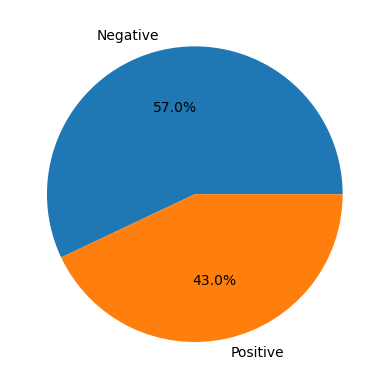

1.3274228064811984


In [339]:
label_count = data_train['target'].value_counts()
labels = ['Negative', 'Positive']

plt.pie(label_count, labels=labels, autopct='%1.1f%%')

plt.show()

print(label_count[0] / label_count[1])

### Examining the distribution plot of the data

It can be seen that there are more negative cases than positive cases. The ratio of negative cases to positive cases is about **1.32.**

Since it is a text data, let's try some wordclouds here.

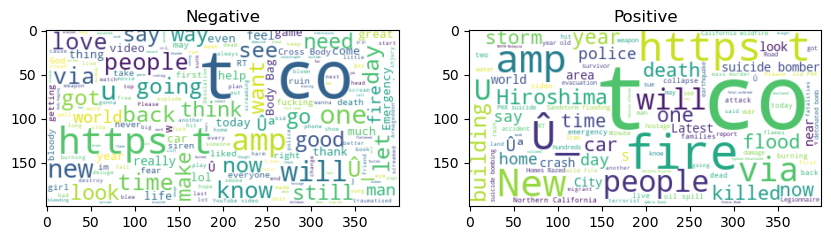

In [340]:
negative_cases = "".join(data_train[data_train['target'] == 0]['text'].values)
positive_cases = "".join(data_train[data_train['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

### Examining wordcloud of the data

I can identify some major words that may help the model distinguish each groups, like **'fire' or 'love',** but also see some redundant texts, like **'t', 'https', or 'co'.**

Let's remove them all for better model performance. Let's iterate through this process a few times.

In [341]:
data_train['text'] = data_train['text'].str.replace(r't|https|co|Û_', '', regex=True)
data_test['text'] = data_test['text'].str.replace(r't|https|co|Û_', '', regex=True)

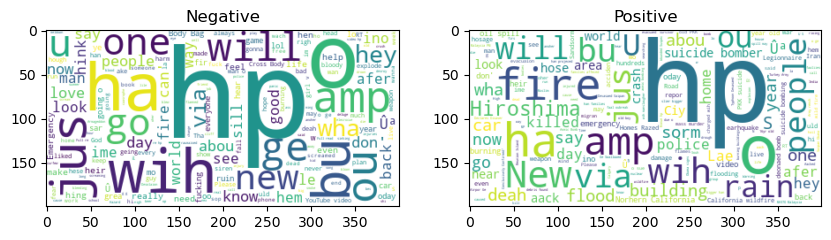

In [342]:
negative_cases = "".join(data_train[data_train['target'] == 0]['text'].values)
positive_cases = "".join(data_train[data_train['target'] == 1]['text'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

wc1 = WordCloud(background_color='white').generate(negative_cases)
wc2 = WordCloud(background_color='white').generate(positive_cases)

axs[0].imshow(wc1, interpolation='bilinear')
axs[0].set_title('Negative')
axs[1].imshow(wc2, interpolation='bilinear')
axs[1].set_title('Positive')

plt.show()

### Examining wordcloud of the data.. again

Okay, they still show some correlations, but I think this should be kinda enough.

In [343]:
sentences_train = data_train['text'].values
sentences_test = data_test['text'].values

## Preparing the training & validation data

In [344]:
print(np.mean([len(text) for text in data_train['text']]))

print(data_train['text'][0])

print(len(data_train['text'][0]))

92.38368580060423
Our Deeds are he Reason of his #earhquake May ALLAH Forgive us all
66


In [345]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences_train)

sequences_train = tokenizer.texts_to_sequences(sentences_train)

# This is used for Embedding layer afterwards
num_words = len(tokenizer.word_index)

print(num_words)

maxlen_tokens = 20

# The reason that the maxlength is different than the true max length is that the texts are tokenized
padded_sequences_train = pad_sequences(sequences_train, maxlen=maxlen_tokens, padding='post', truncating='post')

padded_sequences_train[0]

22952


array([ 109, 4673,   22,    2,  848,    7,   19,  248,  130, 1620, 4674,
         86,   35,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [346]:
num_validation_samples = round(0.2 * len(padded_sequences_train))

seq_train = padded_sequences_train[num_validation_samples:]
labels_train = data_train['target'].values[num_validation_samples:]
seq_validate = padded_sequences_train[:num_validation_samples]
labels_validate = data_train['target'].values[:num_validation_samples]

print(len(seq_train))
print(len(seq_validate))

print(seq_train[0])
print(seq_train.shape)

6090
1523
[ 3240    17   131    51     2   241   201   147     7   175     8 10206
  2547  2332    30   292   515  1101   296     4]
(6090, 20)


## Defining model architecture

I am first going to try out building a **simple RNN with LSTM**, then try a modified version of the first model with **dropout** applied. I will compare these two, and use the better one for submission.

The first model will be as follows:

**Input -> LSTM -> LSTM -> Dense -> Dense -> Output**

I will use **Tanh** as the activation function for the hidden layers because **CuDNNLSTM** supports it, and a mix of **ReLU** and **sigmoid** for the dense layers just before the output.

The additional dense layer is there to increase the model's learning capacity, but it may removed or adjusted in the second model after evaluation.

Also, I will use the **decay** option for the optimizer, hoping to mitigate some problems of RNN like gradient explosion.

## Building the first model

In [347]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=maxlen_tokens))

model.add(CuDNNLSTM(128, return_sequences=True))

model.add(CuDNNLSTM(128))

model.add(Dense(units=256, activation='relu'))

model.add(Dense(units=1, activation='sigmoid'))

model.build(input_shape=(None, maxlen_tokens))

model.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 20, 32)            734464    
                                                                 
 cu_dnnlstm_71 (CuDNNLSTM)   (None, 20, 128)           82944     
                                                                 
 cu_dnnlstm_72 (CuDNNLSTM)   (None, 128)               132096    
                                                                 
 dense_74 (Dense)            (None, 256)               33024     
                                                                 
 dense_75 (Dense)            (None, 1)                 257       
                                                                 
Total params: 982,785
Trainable params: 982,785
Non-trainable params: 0
_________________________________________________________________


## Compiling & training the first model

In [348]:
opt = Adam(learning_rate=0.00001, decay=0.000001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [349]:
hist = model.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=10)

Epoch 1/10
191/191 [==============================] - 4s 11ms/step - loss: 0.6921 - accuracy: 0.5507 - val_loss: 0.6883 - val_accuracy: 0.6211
Epoch 2/10
191/191 [==============================] - 1s 8ms/step - loss: 0.6882 - accuracy: 0.5576 - val_loss: 0.6767 - val_accuracy: 0.6211
Epoch 3/10
191/191 [==============================] - 1s 8ms/step - loss: 0.6815 - accuracy: 0.5576 - val_loss: 0.6614 - val_accuracy: 0.6211
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.6731 - accuracy: 0.5576 - val_loss: 0.6473 - val_accuracy: 0.6211
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6487 - accuracy: 0.5920 - val_loss: 0.6200 - val_accuracy: 0.6619
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.5857 - accuracy: 0.7342 - val_loss: 0.5925 - val_accuracy: 0.6756
Epoch 7/10
191/191 [==============================] - 2s 10ms/step - loss: 0.5103 - accuracy: 0.7703 - val_loss: 0.5946 - val_accuracy: 0.6809
Epoc

## Evaluating the first model

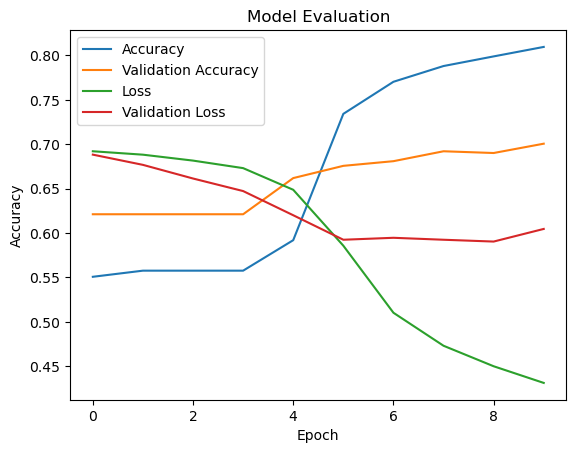

In [350]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

### Examining accuracy plot of of the first model

Even I set the learning rate to be low, it can be seen that the model learns very fast at a point, and also overfits very fast.

I may have to lower the learning rate even more, and perform some measures to mitigate overfitting like dropout.

## Building the second model

This time, I will add some **dropout layers** after the LSTM layers.

In [351]:
model_do = Sequential()

model_do.add(Embedding(num_words, 32, input_length=maxlen_tokens))

model_do.add(CuDNNLSTM(128, return_sequences=True))
model_do.add(Dropout(0.2))

model_do.add(CuDNNLSTM(128))
model_do.add(Dropout(0.2))

model_do.add(Dense(units=256, activation='relu'))

model_do.add(Dense(units=1, activation='sigmoid'))

model_do.build(input_shape=(None, maxlen_tokens))

model_do.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 20, 32)            734464    
                                                                 
 cu_dnnlstm_73 (CuDNNLSTM)   (None, 20, 128)           82944     
                                                                 
 dropout_22 (Dropout)        (None, 20, 128)           0         
                                                                 
 cu_dnnlstm_74 (CuDNNLSTM)   (None, 128)               132096    
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_76 (Dense)            (None, 256)               33024     
                                                                 
 dense_77 (Dense)            (None, 1)               

## Compiling & training the second model

In [352]:
opt_do = Adam(learning_rate=0.00001, decay=0.000001)

model_do.compile(optimizer=opt_do, loss='binary_crossentropy', metrics=['accuracy'])

In [353]:
hist_do = model_do.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=10)

Epoch 1/10
191/191 [==============================] - 4s 13ms/step - loss: 0.6926 - accuracy: 0.5300 - val_loss: 0.6898 - val_accuracy: 0.6211
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6904 - accuracy: 0.5576 - val_loss: 0.6836 - val_accuracy: 0.6211
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6864 - accuracy: 0.5576 - val_loss: 0.6721 - val_accuracy: 0.6211
Epoch 4/10
191/191 [==============================] - 2s 8ms/step - loss: 0.6812 - accuracy: 0.5576 - val_loss: 0.6598 - val_accuracy: 0.6211
Epoch 5/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6735 - accuracy: 0.5576 - val_loss: 0.6463 - val_accuracy: 0.6211
Epoch 6/10
191/191 [==============================] - 2s 9ms/step - loss: 0.6478 - accuracy: 0.6054 - val_loss: 0.6141 - val_accuracy: 0.6671
Epoch 7/10
191/191 [==============================] - 2s 8ms/step - loss: 0.5792 - accuracy: 0.7345 - val_loss: 0.5903 - val_accuracy: 0.6888
Epoch

## Evaluating the second model

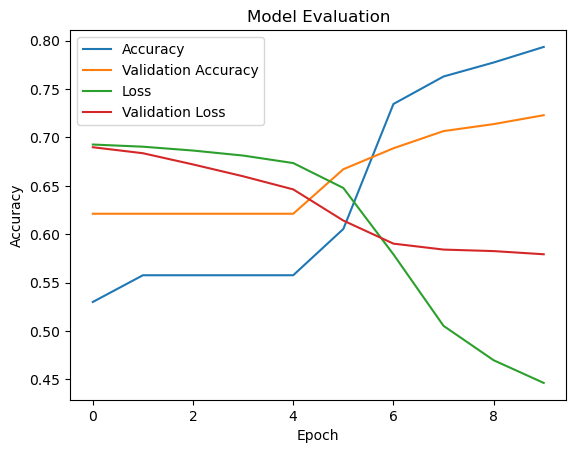

In [354]:
plt.plot(hist_do.history["accuracy"])
plt.plot(hist_do.history['val_accuracy'])
plt.plot(hist_do.history['loss'])
plt.plot(hist_do.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

### Building the second model Examining the accuracy plot of of the second model

Well, even with the dropout applied, the results do not show any significant improvement.

This may have to do with the structure of the model itself rather than parameters I think, let's try fitting a new model based on previous findings.

## Building the final model

In [355]:
model_final = Sequential()

model_final.add(Embedding(num_words, 32, input_length=maxlen_tokens))

model_final.add(CuDNNLSTM(64, return_sequences=True))
model.add(BatchNormalization())

model_final.add(CuDNNLSTM(128))
model.add(BatchNormalization())

model_final.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())

model_final.add(Dense(units=1, activation='sigmoid'))

model_final.build(input_shape=(None, maxlen_tokens))

model_final.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 20, 32)            734464    
                                                                 
 cu_dnnlstm_75 (CuDNNLSTM)   (None, 20, 64)            25088     
                                                                 
 cu_dnnlstm_76 (CuDNNLSTM)   (None, 128)               99328     
                                                                 
 dense_78 (Dense)            (None, 256)               33024     
                                                                 
 dense_79 (Dense)            (None, 1)                 257       
                                                                 
Total params: 892,161
Trainable params: 892,161
Non-trainable params: 0
_________________________________________________________________


## Compiling & training the final model

In [356]:
opt_final = Adam(learning_rate=0.00001, decay=0.000001)

model_final.compile(optimizer=opt_final, loss='binary_crossentropy', metrics=['accuracy'])

In [357]:
hist_final = model_final.fit(seq_train, labels_train, validation_data=(seq_validate, labels_validate), epochs=15)

Epoch 1/15
191/191 [==============================] - 3s 9ms/step - loss: 0.6921 - accuracy: 0.5484 - val_loss: 0.6885 - val_accuracy: 0.6211
Epoch 2/15
191/191 [==============================] - 1s 7ms/step - loss: 0.6892 - accuracy: 0.5576 - val_loss: 0.6808 - val_accuracy: 0.6211
Epoch 3/15
191/191 [==============================] - 1s 7ms/step - loss: 0.6846 - accuracy: 0.5576 - val_loss: 0.6686 - val_accuracy: 0.6211
Epoch 4/15
191/191 [==============================] - 1s 7ms/step - loss: 0.6787 - accuracy: 0.5576 - val_loss: 0.6572 - val_accuracy: 0.6211
Epoch 5/15
191/191 [==============================] - 1s 7ms/step - loss: 0.6680 - accuracy: 0.5583 - val_loss: 0.6415 - val_accuracy: 0.6231
Epoch 6/15
191/191 [==============================] - 1s 7ms/step - loss: 0.6373 - accuracy: 0.6289 - val_loss: 0.6082 - val_accuracy: 0.6756
Epoch 7/15
191/191 [==============================] - 2s 10ms/step - loss: 0.5807 - accuracy: 0.7346 - val_loss: 0.5909 - val_accuracy: 0.6901
Epoch

## Evaluating the final model

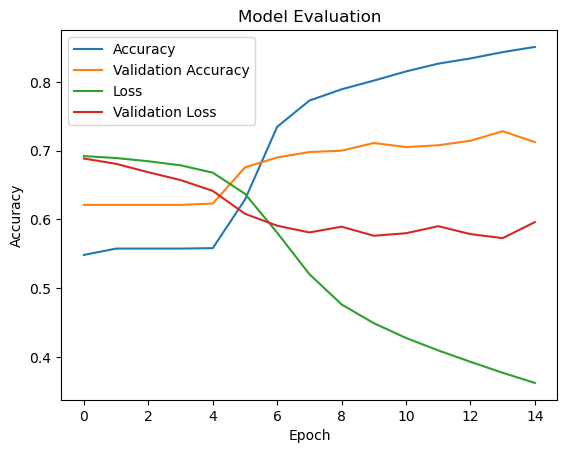

In [358]:
plt.plot(hist_final.history["accuracy"])
plt.plot(hist_final.history['val_accuracy'])
plt.plot(hist_final.history['loss'])
plt.plot(hist_final.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

### Examining the accuracy plot of of the final model

Ok, with **batch normalization** instead of dropout layers, the accuracy went a bit higher, and the loss has become quite low.

The metric for validation does not show big improvements, but still, I think this is the best model among the three ones that I have.

The final accuracy for training data is : **accuracy: 0.8507**, and accuracy for validation data is : **val_accuracy: 0.7124**.

## Conclusion

A simple **RNN model with LSTM** showed moderate performance for classifying tokenized twitter texts, but the training metrics showed some strange behaviors of starting really slow, and just mooning at a certain point. This may be due to **gradient explosion,** one of undesired characteristics of RNN models.

Applying **dropout layers** did not show significant improvement in performance, while applying **batch normalization layers** did.

Next time, I will spend more time on preprocessing the data, since I think that I could have achieved better performance with properly treated data for these kind of NLP problems.

## Submission

In [366]:
sequences_test = tokenizer.texts_to_sequences(sentences_test)

padded_sequences_test = pad_sequences(sequences_test, maxlen=maxlen_tokens, padding='post', truncating='post')

padded_sequences_test[0]

array([  32,  896,    3, 2566,  121,   89,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [367]:
predictions = model_final.predict(padded_sequences_test, verbose=1)

102/102 [==============================] - 0s 3ms/step


In [368]:
print(predictions)

[[0.48363817]
 [0.7638647 ]
 [0.96370125]
 ...
 [0.9603013 ]
 [0.95367485]
 [0.6089641 ]]


In [370]:
pred = np.transpose(predictions)[0]

print(pred)

submission_df = pd.DataFrame()
submission_df['id'] = data_test['id']
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))

print(submission_df.head())

submission_df['target'].value_counts()

[0.48363817 0.7638647  0.96370125 ... 0.9603013  0.95367485 0.6089641 ]
   id  target
0   0       0
1   2       1
2   3       1
3   9       0
4  11       1


0    2079
1    1184
Name: target, dtype: int64

In [ ]:
submission_df.to_csv('submission.csv', index=False)